# Key Question

Why are there bad comments?  
Is it due to late deliveries? Defective products?

If it is due to bad delivery, why?

Sélectionner un produit et ressortie les mots la ou les raisons des notes négatives

# Preprocessing

### Import and files

In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from tqdm import tqdm

from PIL import Image
import random
import unicodedata
import re

nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BEP29\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BEP29\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [121]:
import os
import warnings

for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings('ignore')


.\.gitignore
.\red_string.ipynb
.\.vscode\settings.json
.\data\olist_customers_dataset.csv
.\data\olist_geolocation_dataset.csv
.\data\olist_orders_dataset.csv
.\data\olist_order_items_dataset.csv
.\data\olist_order_payments_dataset.csv
.\data\olist_order_reviews_dataset.csv
.\data\olist_products_dataset.csv
.\data\olist_sellers_dataset.csv
.\data\product_category_name_translation.csv
.\input\thumbs_down.png
.\input\thumbs_up.png


### Open Files

In [122]:
order_s = pd.read_csv('./data/olist_orders_dataset.csv')
# customer_s = pd.read_csv('./data/olist_customers_dataset.csv')
# payment = pd.read_csv('./data/olist_order_payments_dataset.csv')
order_item = pd.read_csv('./data/olist_order_items_dataset.csv')
# product = pd.read_csv('./data/olist_products_dataset.csv')
reviews = pd.read_csv('./data/olist_order_reviews_dataset.csv')
# category = pd.read_csv('./data/product_category_name_translation.csv')
# cat_name_translation = pd.read_csv(
#     './data/product_category_name_translation.csv')


In [123]:
print(
    'orders data shape:',
    order_s.shape,
    # '\ncustomer data shape:',
    # customer_s.shape,
    # '\npayment data shape:',
    # payment.shape,
    '\norder_item data shape:',
    order_item.shape,
    # '\nproduct data shape:',
    # product.shape,
    '\nreview data shape:',
    reviews.shape,
    # '\nlanguage data shape:',
    # cat_name_translation.shape,
)


orders data shape: (99441, 8) 
order_item data shape: (112650, 7) 
review data shape: (99224, 7)


In [124]:
order_s.head(15)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06 00:00:00
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23 00:00:00


In [125]:
order_item.head(15)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69
6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85
7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
9,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40


In [126]:
reviews.head(15)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


### Convert DateTime & Merge Table

In [127]:
reviews['review_creation_date'] = pd.to_datetime(
    reviews['review_creation_date'], format='%Y/%m/%d %H:%M:%S')
reviews['review_answer_timestamp'] = pd.to_datetime(
    reviews['review_answer_timestamp'], format='%Y/%m/%d %H:%M:%S')
order_s['order_purchase_timestamp'] = pd.to_datetime(
    order_s['order_purchase_timestamp'], format='%Y/%m/%d %H:%M:%S')
order_s['order_delivered_customer_date'] = pd.to_datetime(
    order_s['order_delivered_customer_date'], format='%Y/%m/%d %H:%M:%S')


In [128]:
reviews = pd.merge(reviews, order_s, on='order_id')


In [129]:
to_drop = [
    'review_id', 'customer_id', 'review_comment_title',
    'order_approved_at', 'order_delivered_carrier_date',
    'order_estimated_delivery_date'
]
reviews.drop(columns=to_drop, inplace=True)
reviews


,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_delivered_customer_date
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,2018-01-18,2018-01-18 21:46:59,delivered,2018-01-11 15:30:49,2018-01-17 18:42:41
1,a548910a1c6147796b98fdf73dbeba33,5,NaN,2018-03-10,2018-03-11 03:05:13,delivered,2018-02-28 12:25:19,2018-03-09 23:17:20
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,2018-02-17,2018-02-18 14:36:24,delivered,2018-02-03 09:56:22,2018-02-16 17:28:48
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,delivered,2017-04-09 17:41:13,2017-04-20 09:08:35
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,delivered,2018-02-10 10:59:03,2018-02-28 16:33:35
...,...,...,...,...,...,...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,5,NaN,2018-07-07,2018-07-14 17:18:30,delivered,2018-06-27 17:31:29,2018-07-06 13:22:37
99220,22ec9f0669f784db00fa86d035cf8602,5,NaN,2017-12-09,2017-12-11 20:06:42,delivered,2017-12-03 21:45:23,2017-12-08 17:19:00
99221,55d4004744368f5571d1f590031933e4,5,"Excelente mochila, entrega super rápida. Super...",2018-03-22,2018-03-23 09:10:43,delivered,2018-03-18 09:52:19,2018-03-21 17:44:08
99222,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,2018-07-01,2018-07-02 12:59:13,delivered,2018-06-22 16:47:28,2018-06-30 12:57:51


In [130]:
reviews_na = reviews.where(reviews.isna() == False).dropna()
reviews_na.head(15)


,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_delivered_customer_date
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,delivered,2017-04-09 17:41:13,2017-04-20 09:08:35
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,delivered,2018-02-10 10:59:03,2018-02-28 16:33:35
9,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22,2018-05-23 16:45:47,delivered,2018-05-14 10:29:02,2018-05-21 17:52:12
12,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16,2018-02-20 10:52:22,delivered,2018-02-12 16:07:34,2018-02-15 19:16:54
15,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23,2018-05-24 03:00:01,delivered,2018-05-18 18:20:45,2018-05-22 14:58:47
16,0dacf04c5ad59fd5a0cc1faa07c34e39,2,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",2018-01-18,2018-01-20 21:25:45,delivered,2017-12-19 13:14:37,2018-02-21 01:25:41
22,4fc44d78867142c627497b60a7e0228a,5,Loja nota 10,2018-07-10,2018-07-11 14:10:25,delivered,2018-07-04 20:34:57,2018-07-09 20:27:50
24,79832b7cb59ac6f887088ffd686e1d5e,5,obrigado pela atençao amim dispensada,2017-12-01,2017-12-09 22:58:58,delivered,2017-11-21 08:52:33,2017-12-01 00:33:58
27,2ca73e2ff9e3a186ad1e1ffb9b1d9c10,5,A compra foi realizada facilmente.\r\nA entreg...,2018-03-23,2018-04-01 00:27:51,delivered,2018-03-18 21:01:32,2018-03-23 00:32:34
28,68b3cbc68e4cd1fe19bec35f1d3bb7ee,5,relógio muito bonito e barato.,2018-03-29,2018-04-02 14:19:31,delivered,2018-03-10 00:42:20,2018-03-28 18:13:06


### Average & Percentage

In [131]:
ps_5 = len(reviews[reviews['review_score'] == 5]) * 100 / len(reviews)
ps_1 = len(reviews[reviews['review_score'] == 1]) * 100 / len(reviews)
avg_s = reviews['review_score'].mean()

print(
    f'Total number of reviews: {len(reviews)}',
    '\nPercentage of 5 star reviews: {:.2f}%'.format(ps_5),
    '\nPercentage of 1 star reviews: {:.2f}%'.format(ps_1),
    '\nAverage review score: {:.2f}'.format(avg_s),
)


Total number of reviews: 99224 
Percentage of 5 star reviews: 57.78% 
Percentage of 1 star reviews: 11.51% 
Average review score: 4.09


In [132]:
ps_5 = len(reviews_na[reviews_na['review_score'] == 5]) * 100 / len(reviews_na)
ps_1 = len(reviews_na[reviews_na['review_score'] == 1]) * 100 / len(reviews_na)
avg_s = reviews_na['review_score'].mean()

print(
    f'Total number of reviews: {len(reviews_na)}',
    '\nPercentage of 5 star reviews: {:.2f}%'.format(ps_5),
    '\nPercentage of 1 star reviews: {:.2f}%'.format(ps_1),
    '\nAverage review score: {:.2f}'.format(avg_s),
)


Total number of reviews: 39100 
Percentage of 5 star reviews: 52.29% 
Percentage of 1 star reviews: 18.65% 
Average review score: 3.77


### Play with Seaborn

In [153]:
sns.set()

COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette(
    (COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})

resize_plot = lambda: plt.gcf().set_size_inches(15, 5)


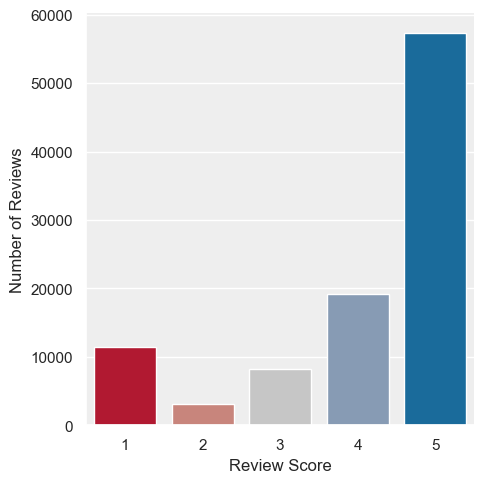

In [134]:
sns.catplot(x='review_score',
            kind='count',
            data=reviews,
            palette=REVIEWS_PALETTE).set(
                xlabel='Review Score',
                ylabel='Number of Reviews',
            )


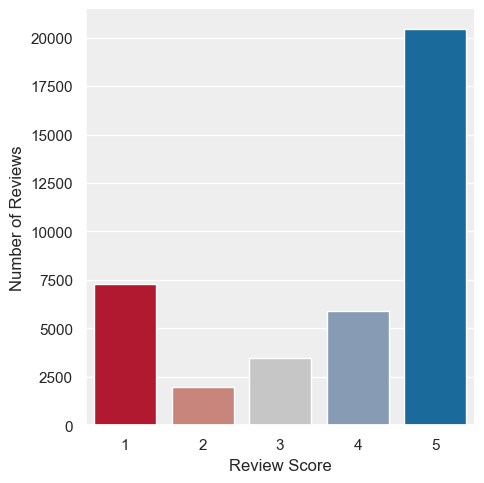

In [135]:
sns.catplot(x='review_score',
            kind='count',
            data=reviews_na,
            palette=REVIEWS_PALETTE).set(
                xlabel='Review Score',
                ylabel='Number of Reviews',
            )


[Text(0.5, 0, 'Order Purchase Timestamp'),
 Text(0, 0.5, 'Review Creation Delay'),
 (17059.511550925927, 17808.25038773148)]

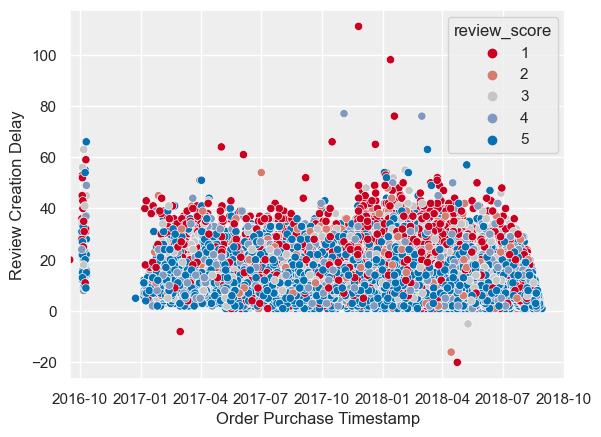

In [136]:
reviews_na['review_creation_delay'] = (
    reviews_na['review_creation_date'] -
    reviews_na['order_purchase_timestamp']).dt.days

sns.scatterplot(x='order_purchase_timestamp',
                y=reviews_na['review_creation_delay'],
                hue='review_score',
                data=reviews,
                palette=REVIEWS_PALETTE).set(
                    xlabel='Order Purchase Timestamp',
                    ylabel='Review Creation Delay',
                    xlim=(reviews_na['order_purchase_timestamp'].min()))


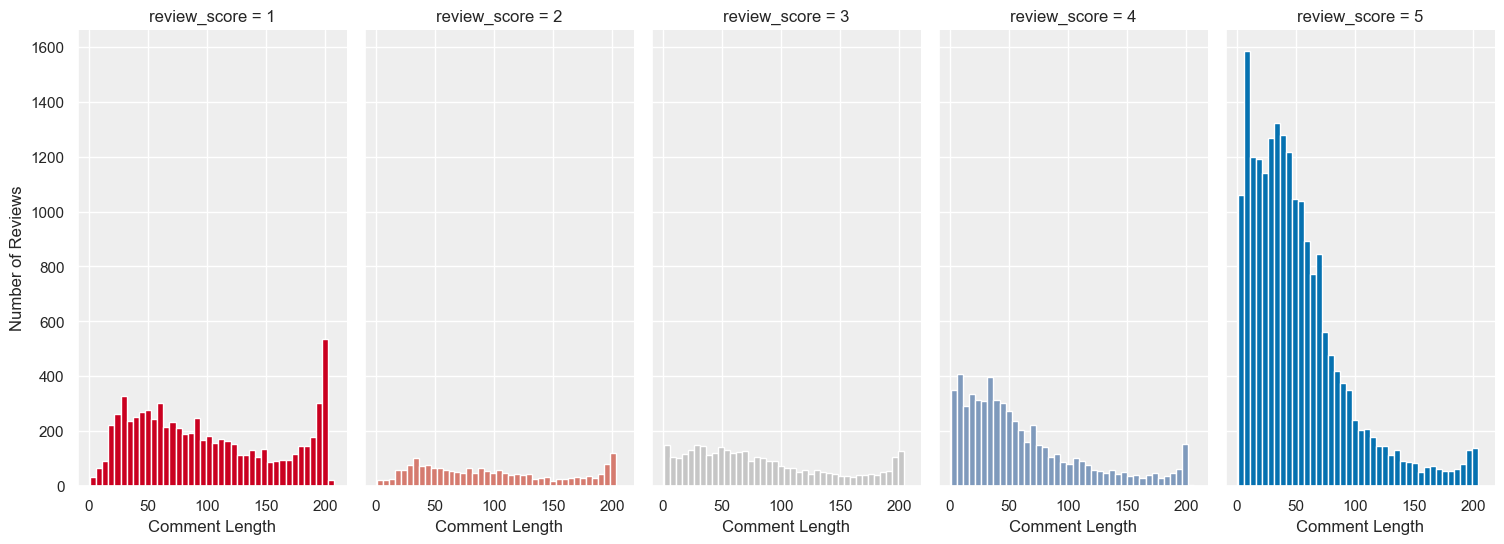

In [137]:
reviews_na['review_length'] = reviews_na['review_comment_message'].str.len()

g = sns.FacetGrid(data=reviews_na,
                  col='review_score',
                  hue='review_score',
                  palette=REVIEWS_PALETTE)
g.map(plt.hist, 'review_length', bins=40)
g.set_xlabels('Comment Length')
g.set_ylabels('Number of Reviews')
plt.gcf().set_size_inches(15, 7)


### Tokenization

In [138]:
avg = sum([len(rv.split()) for rv in reviews_na['review_comment_message']
           ]) / len(reviews_na['review_comment_message'])
avg


11.445217391304348

In [139]:
reviews_na['review_comment_message'] = reviews_na[
    'review_comment_message'].str.lower()
reviews_na['review_comment_message'][3:4]


12    mas um pouco ,travando...pelo valor ta boa.\r\n
Name: review_comment_message, dtype: object

With Python's librairies

In [140]:
tk_py = list()
for rv in tqdm(reviews_na['review_comment_message']):
    tk_py.append(rv.split())

print(tk_py[:20])


100%|██████████| 39100/39100 [00:00<00:00, 96938.97it/s]

[['recebi', 'bem', 'antes', 'do', 'prazo', 'estipulado.'], ['parabéns', 'lojas', 'lannister', 'adorei', 'comprar', 'pela', 'internet', 'seguro', 'e', 'prático', 'parabéns', 'a', 'todos', 'feliz', 'páscoa'], ['aparelho', 'eficiente.', 'no', 'site', 'a', 'marca', 'do', 'aparelho', 'esta', 'impresso', 'como', '3desinfector', 'e', 'ao', 'chegar', 'esta', 'com', 'outro', 'nome...atualizar', 'com', 'a', 'marca', 'correta', 'uma', 'vez', 'que', 'é', 'o', 'mesmo', 'aparelho'], ['mas', 'um', 'pouco', ',travando...pelo', 'valor', 'ta', 'boa.'], ['vendedor', 'confiável,', 'produto', 'ok', 'e', 'entrega', 'antes', 'do', 'prazo.'], ['gostaria', 'de', 'saber', 'o', 'que', 'houve,', 'sempre', 'recebi', 'e', 'essa', 'compra', 'agora', 'me', 'decpcionou'], ['loja', 'nota', '10'], ['obrigado', 'pela', 'atençao', 'amim', 'dispensada'], ['a', 'compra', 'foi', 'realizada', 'facilmente.', 'a', 'entrega', 'foi', 'efetuada', 'muito', 'antes', 'do', 'prazo', 'dado.', 'o', 'produto', 'já', 'começou', 'a', 'ser'

With REGEX

In [141]:
tk_rgx = list()
for rv in tqdm(reviews_na['review_comment_message']):
    tk_rgx.append(re.findall('[\w]+', rv))

print(tk_rgx[:20])


100%|██████████| 39100/39100 [00:00<00:00, 98156.83it/s] 

[['recebi', 'bem', 'antes', 'do', 'prazo', 'estipulado'], ['parabéns', 'lojas', 'lannister', 'adorei', 'comprar', 'pela', 'internet', 'seguro', 'e', 'prático', 'parabéns', 'a', 'todos', 'feliz', 'páscoa'], ['aparelho', 'eficiente', 'no', 'site', 'a', 'marca', 'do', 'aparelho', 'esta', 'impresso', 'como', '3desinfector', 'e', 'ao', 'chegar', 'esta', 'com', 'outro', 'nome', 'atualizar', 'com', 'a', 'marca', 'correta', 'uma', 'vez', 'que', 'é', 'o', 'mesmo', 'aparelho'], ['mas', 'um', 'pouco', 'travando', 'pelo', 'valor', 'ta', 'boa'], ['vendedor', 'confiável', 'produto', 'ok', 'e', 'entrega', 'antes', 'do', 'prazo'], ['gostaria', 'de', 'saber', 'o', 'que', 'houve', 'sempre', 'recebi', 'e', 'essa', 'compra', 'agora', 'me', 'decpcionou'], ['loja', 'nota', '10'], ['obrigado', 'pela', 'atençao', 'amim', 'dispensada'], ['a', 'compra', 'foi', 'realizada', 'facilmente', 'a', 'entrega', 'foi', 'efetuada', 'muito', 'antes', 'do', 'prazo', 'dado', 'o', 'produto', 'já', 'começou', 'a', 'ser', 'usad

With NLTK

In [142]:
tk_nltk = list()
for rv in tqdm(reviews_na['review_comment_message']):
    tk_nltk.append(nltk.tokenize.word_tokenize(rv))

print(tk_nltk[:20])


100%|██████████| 39100/39100 [00:08<00:00, 4770.01it/s]

[['recebi', 'bem', 'antes', 'do', 'prazo', 'estipulado', '.'], ['parabéns', 'lojas', 'lannister', 'adorei', 'comprar', 'pela', 'internet', 'seguro', 'e', 'prático', 'parabéns', 'a', 'todos', 'feliz', 'páscoa'], ['aparelho', 'eficiente', '.', 'no', 'site', 'a', 'marca', 'do', 'aparelho', 'esta', 'impresso', 'como', '3desinfector', 'e', 'ao', 'chegar', 'esta', 'com', 'outro', 'nome', '...', 'atualizar', 'com', 'a', 'marca', 'correta', 'uma', 'vez', 'que', 'é', 'o', 'mesmo', 'aparelho'], ['mas', 'um', 'pouco', ',', 'travando', '...', 'pelo', 'valor', 'ta', 'boa', '.'], ['vendedor', 'confiável', ',', 'produto', 'ok', 'e', 'entrega', 'antes', 'do', 'prazo', '.'], ['gostaria', 'de', 'saber', 'o', 'que', 'houve', ',', 'sempre', 'recebi', 'e', 'essa', 'compra', 'agora', 'me', 'decpcionou'], ['loja', 'nota', '10'], ['obrigado', 'pela', 'atençao', 'amim', 'dispensada'], ['a', 'compra', 'foi', 'realizada', 'facilmente', '.', 'a', 'entrega', 'foi', 'efetuada', 'muito', 'antes', 'do', 'prazo', 'dad

### Basic NLP

In [143]:
def remove_accents(ptg: float) -> str:
    return unicodedata.normalize('NFKD',
                                 ptg).encode('ascii',
                                             errors='ignore').decode('utf-8')


STOP_WORDS = set(
    remove_accents(w) for w in tqdm(nltk.corpus.stopwords.words('portuguese')))

100%|██████████| 207/207 [00:00<00:00, 137812.85it/s]


This next words will be useful to delete and add later

In [144]:
STOP_WORDS.remove('nao')
STOP_WORDS.add('produto')

In [195]:
def tokenize(data: str) -> tuple:
    normalized = remove_accents(data)
    tokens = nltk.tokenize.word_tokenize(normalized)
    # tokens = re.findall('[\w]+', normalized)
    return tuple(
        [tk for tk in tokens if tk not in STOP_WORDS and tk.isalpha()])


def ngrams(tokens: tuple) -> list:
    unigrams, bigrams, trigrams = [], [], []
    for tk in tqdm(tokens):
        unigrams.extend(tk)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(tk))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(tk))

    return unigrams, bigrams, trigrams


In [146]:
reviews_na['review_comment_words'] = reviews_na[
    'review_comment_message'].apply(tokenize)

reviews_5s = reviews_na[reviews_na['review_score'] == 5]
reviews_1s = reviews_na[reviews_na['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = ngrams(
    reviews_5s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = ngrams(
    reviews_1s['review_comment_words'])


100%|██████████| 7293/7293 [00:00<00:00, 81415.81it/s]


Then, we can display the frequency distribution for the most and the lowest rattings

In [157]:
def plot_freq(tokens: tuple, color: str) -> None:
    resize_plot()
    nltk.FreqDist(tokens).plot(30, cumulative=False, color=color)


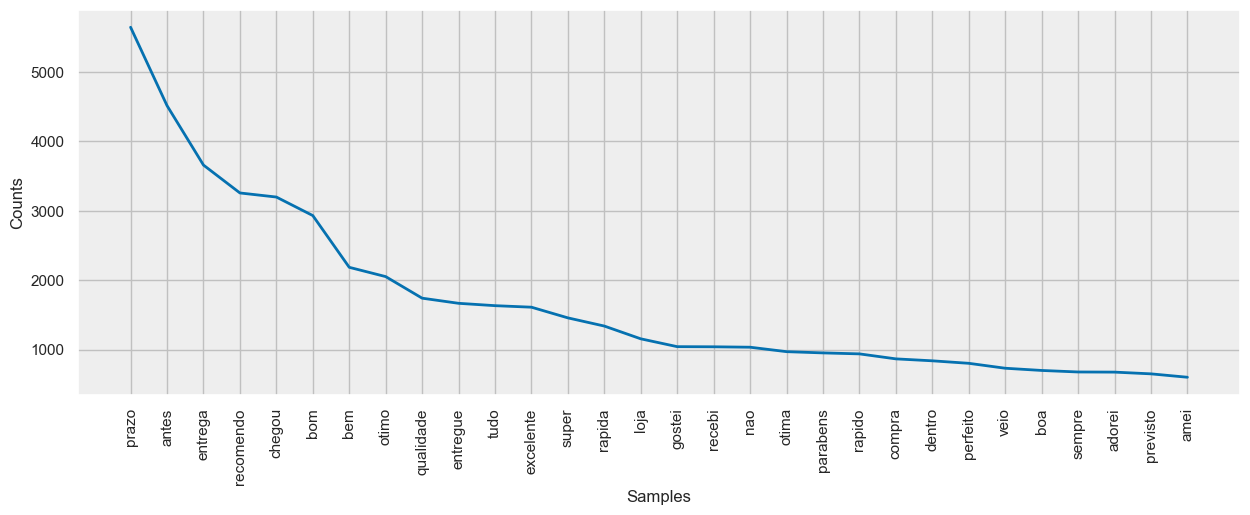

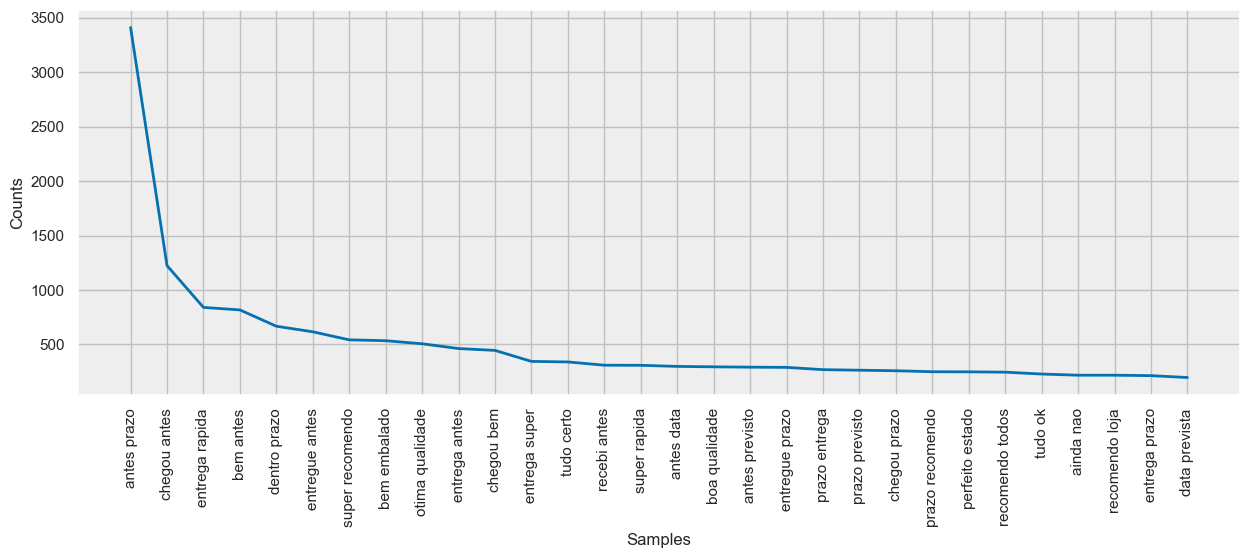

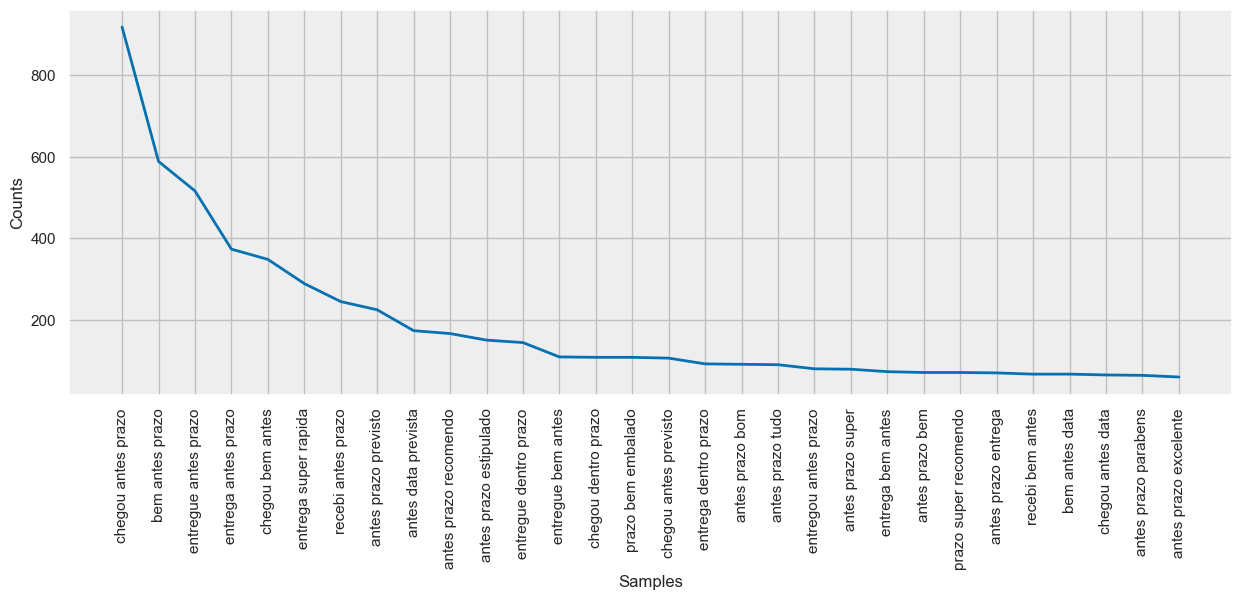

In [158]:
plot_freq(unigrams_5s, COLOR_5S)
plot_freq(bigrams_5s, COLOR_5S)
plot_freq(trigrams_5s, COLOR_5S)


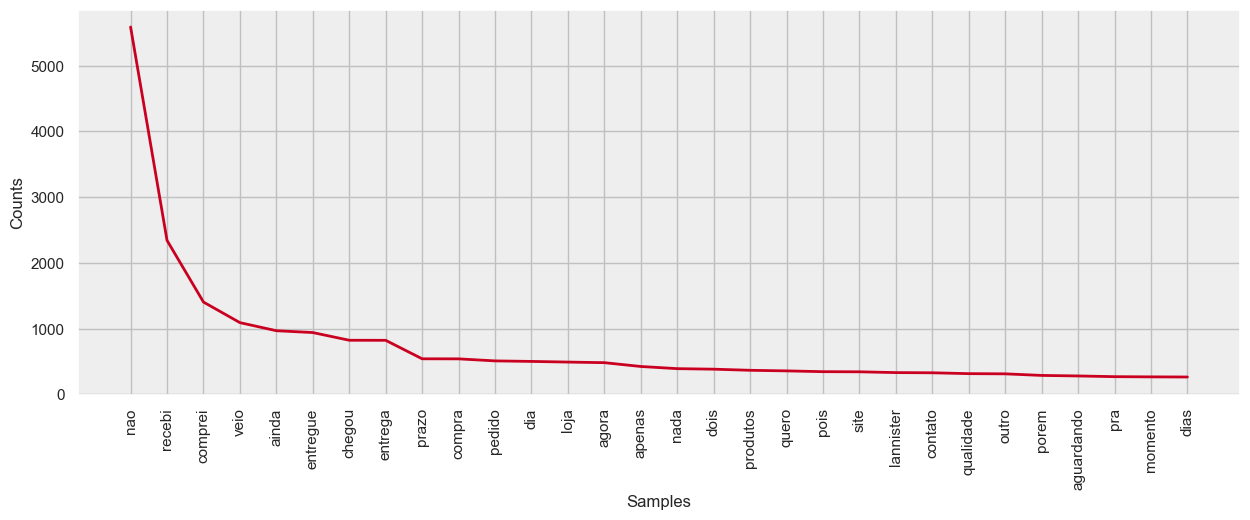

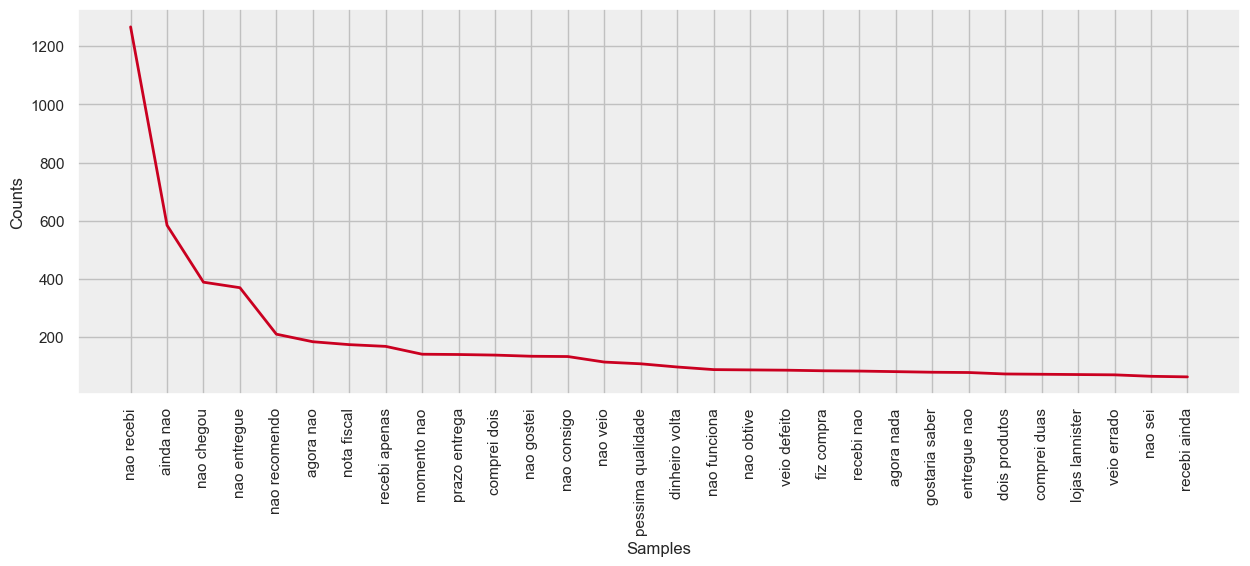

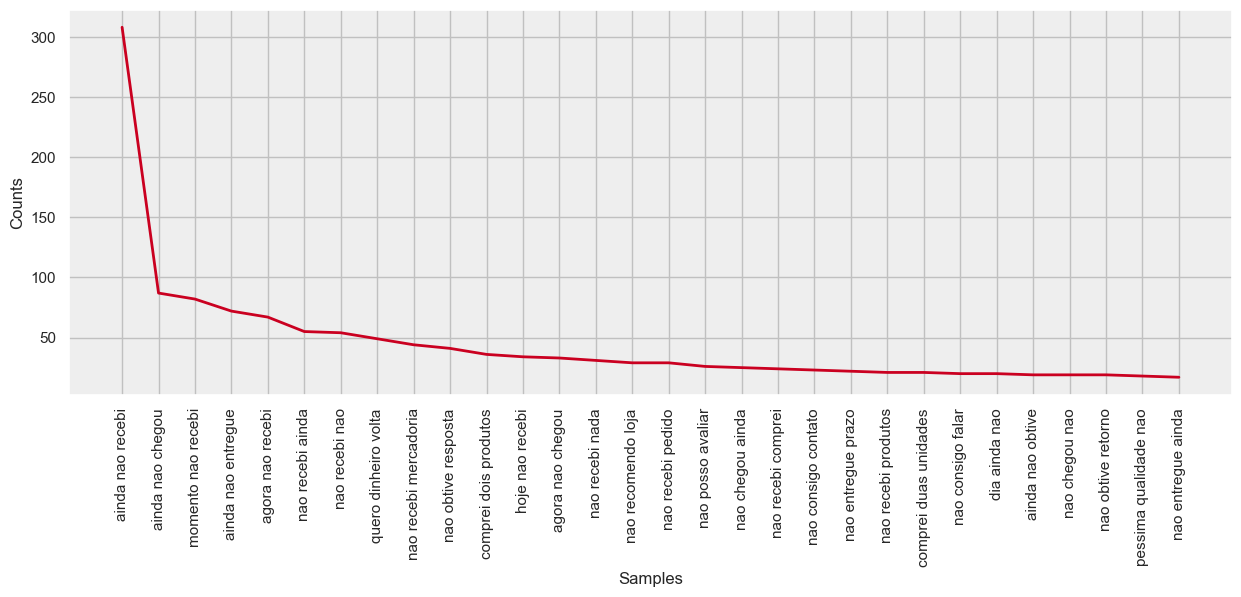

In [159]:
plot_freq(unigrams_1s, COLOR_1S)
plot_freq(bigrams_1s, COLOR_1S)
plot_freq(trigrams_1s, COLOR_1S)


As we can see, the lowest rattings is not clear and we need a little bit more precision

100%|██████████| 4801/4801 [00:00<00:00, 32632.01it/s]


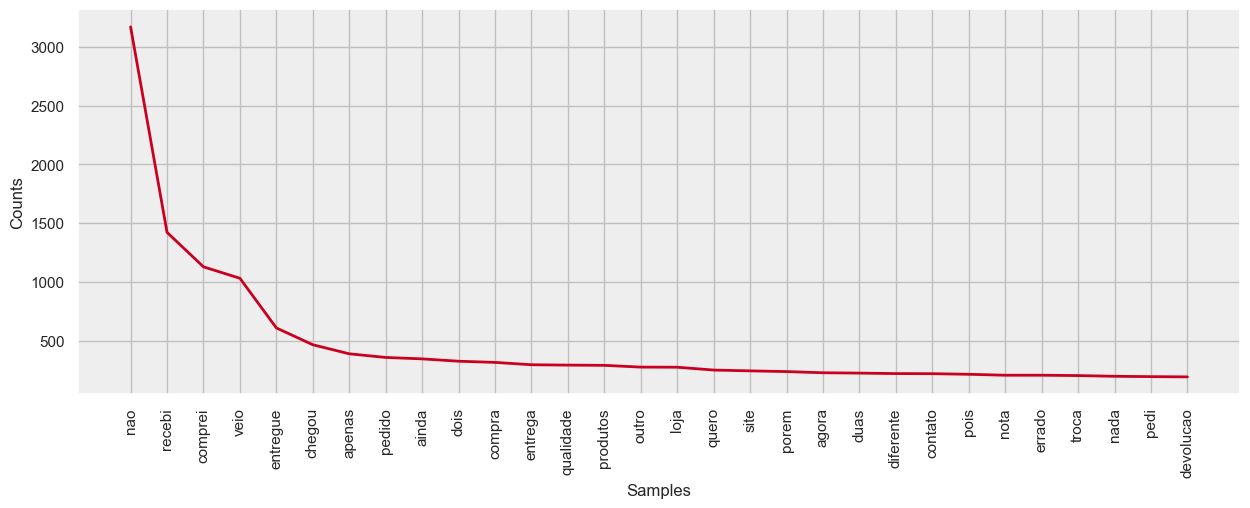

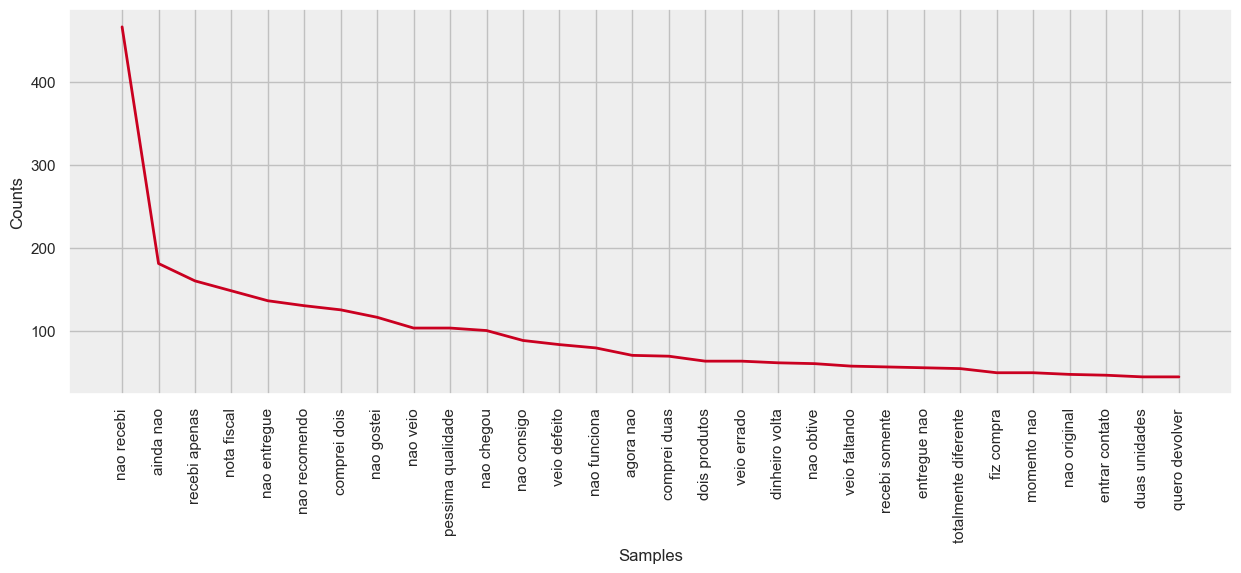

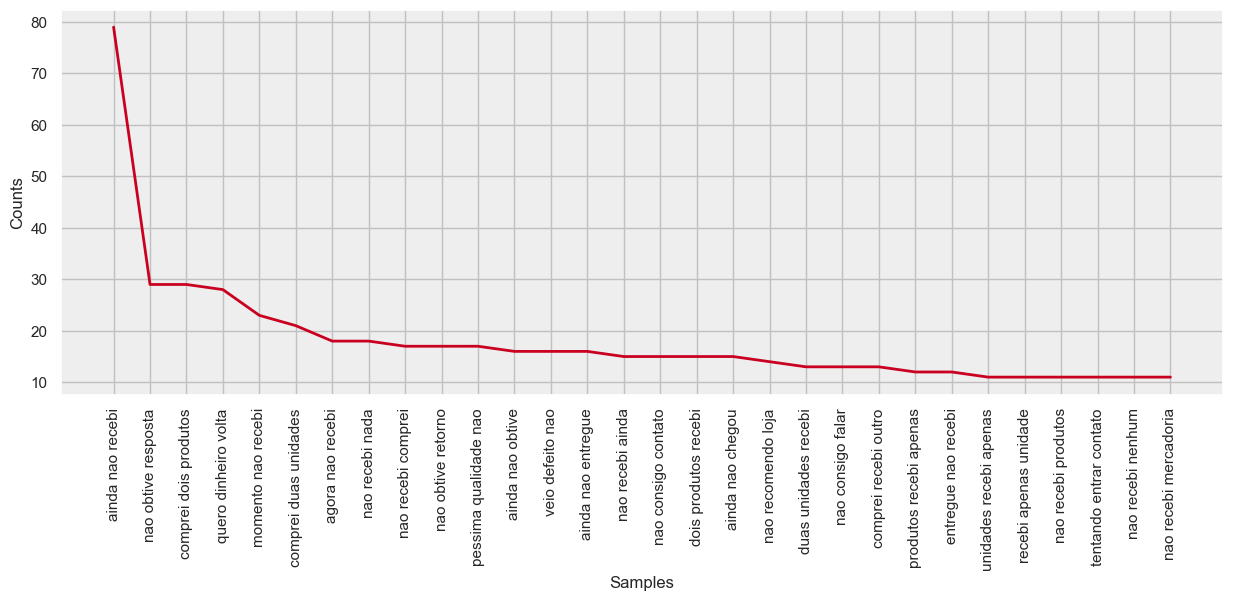

In [160]:
reviews_delivered_1s = reviews_na[(reviews_na['review_score'] == 1) &
                                  (reviews_na['order_delivered_customer_date']
                                   < reviews_na['review_creation_date'])]
                                   
unigrams_d1s, bigrams_d1s, trigrams_d1s = ngrams(
    reviews_delivered_1s['review_comment_words'])

plot_freq(unigrams_d1s, COLOR_1S)
plot_freq(bigrams_d1s, COLOR_1S)
plot_freq(trigrams_d1s, COLOR_1S)


Here, I've made a function who is responding to the demand of the client. After you gave it product Id, it will returns you a dataset of all reviews delivered with some statistics.


In [245]:
def search_product(product_id: str, dataframe: bool = True, stats: bool = True) -> pd.DataFrame:
    print(f'Product searched: {product_id}')

    product_link = order_item[order_item['product_id'] == product_id]

    if len(product_link) == 0:
        return print(f'\nThis product\'s id {product_id} was not found')

    reviews_order = reviews_na[reviews_na['order_id'].isin(
        product_link['order_id'])]

    if len(reviews_order) == 0:
        return print(f'\nThere no reviews founded for {product_id}')

    if stats:
        rev_len = len(reviews_order)

        ps_5 = len(reviews_order[reviews_order['review_score'] ==
                                 5]) * 100 / rev_len
        ps_1 = len(reviews_order[reviews_order['review_score'] ==
                                 1]) * 100 / rev_len
        avg_s = reviews_order['review_score'].mean()

        print(
            f'\nTotal number of reviews: {rev_len}',
            '\nPercentage of 5 star reviews: {:.2f}%'.format(ps_5),
            '\nPercentage of 1 star reviews: {:.2f}%'.format(ps_1),
            '\nAverage review score: {:.2f}'.format(avg_s),
        )

    if dataframe: return reviews_order


Then I tried it on a totaly random product.

In [246]:
reviews_prod = search_product(product_id='52c80cedd4e90108bf4fa6a206ef6b03',
                              dataframe=True,
                              stats=True)

print('Dataframe vide ?!'
      ) if reviews_prod.empty is True else reviews_prod.head()


Product searched: 99a4788cb24856965c36a24e339b6058

Total number of reviews: 216 
Percentage of 5 star reviews: 43.52% 
Percentage of 1 star reviews: 18.98% 
Average review score: 3.59


,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_delivered_customer_date,review_creation_delay,review_length,review_comment_words
144,54b73f808b0ff25da4276773c30ac269,5,gostei muito do jogo de banho.a estampa florid...,2017-06-03,2017-06-04 02:22:55,delivered,2017-05-27 16:31:57,2017-06-02 16:03:41,6,93,"(gostei, jogo, estampa, florida, bordado, tudo..."
190,935f0d2ac8ce7ce29f5712d2637ddb33,5,muito bom,2018-02-20,2018-02-21 09:42:27,delivered,2018-02-08 16:33:49,2018-02-19 23:39:07,11,9,"(bom,)"
645,d8253682886103126c169f93e8b46349,3,ainda não recebi o produto,2017-11-18,2017-11-19 00:10:34,delivered,2017-11-03 09:02:50,2017-11-17 20:18:52,14,26,"(ainda, nao, recebi)"
854,4642ed1845e7cd193a89f622e9f4611b,1,não recebi o jogo na cor tabaco. só o vermelho.,2017-08-17,2017-08-18 13:29:27,delivered,2017-08-10 21:17:47,2017-08-16 18:32:23,6,48,"(nao, recebi, jogo, cor, tabaco, vermelho)"
986,c679e1baef76a7cf123dc697fe11c7ad,3,"esperava mais, as toalhas poderiam ser mais gr...",2017-09-06,2017-09-07 01:11:37,delivered,2017-08-19 20:44:22,2017-09-05 17:18:03,17,52,"(esperava, toalhas, poderiam, grossas)"


In [247]:
reviews_prod['review_comment_words'] = reviews_prod[
    'review_comment_message'].apply(tokenize)

reviews_5s = reviews_prod[reviews_prod['review_score'] == 5]
reviews_1s = reviews_prod[reviews_prod['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = ngrams(
    reviews_5s['review_comment_words'])

unigrams_1s, bigrams_1s, trigrams_1s = ngrams(
    reviews_1s['review_comment_words'])


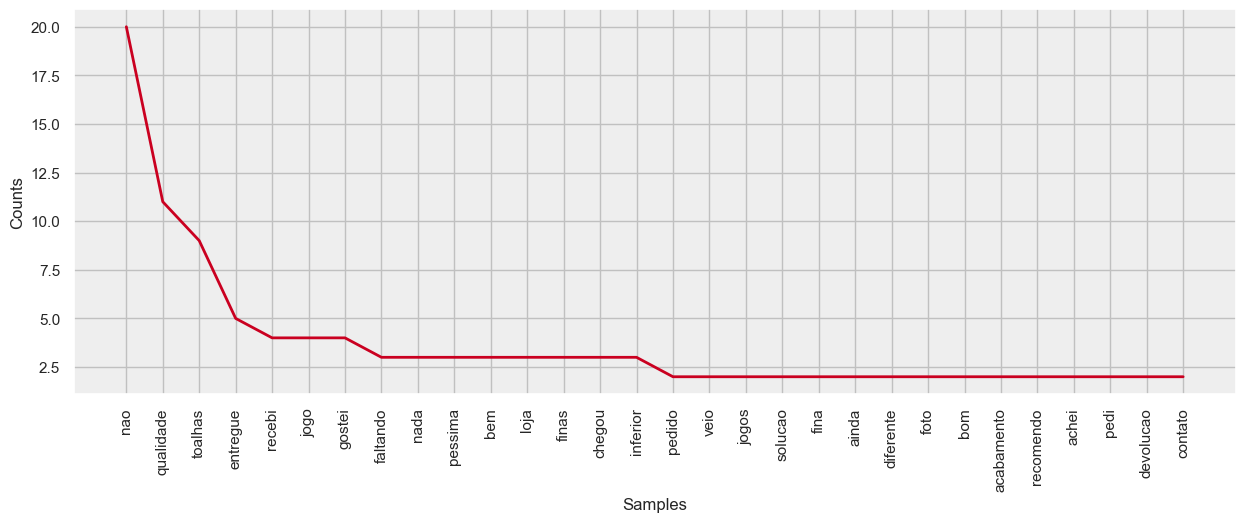

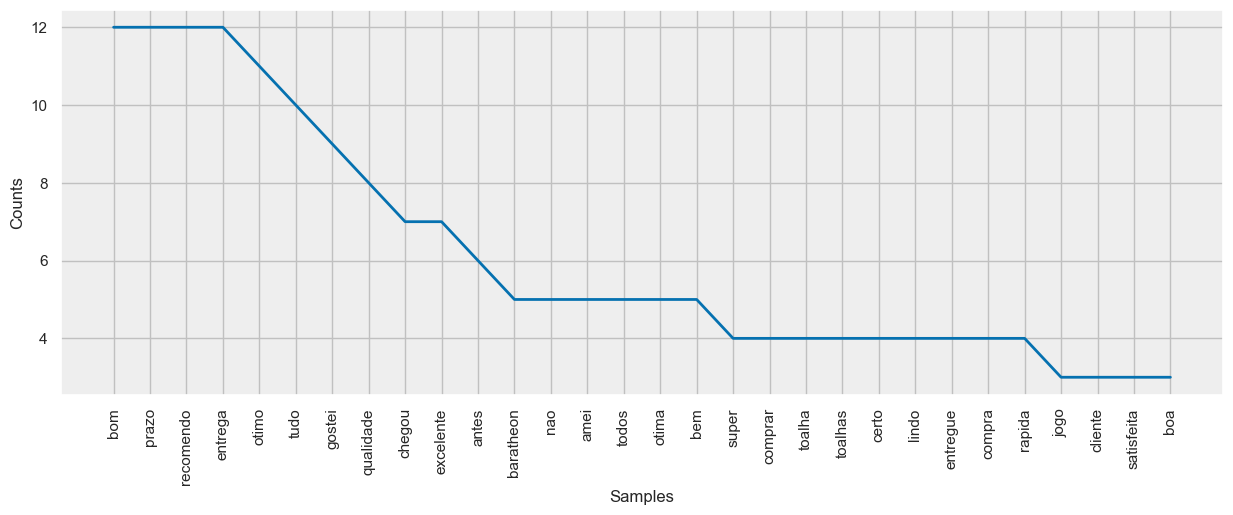

In [248]:
reviews_delivered_1s = reviews_prod[(reviews_prod['review_score'] == 1) & (
    reviews_prod['order_delivered_customer_date'] <
    reviews_prod['review_creation_date'])]
reviews_delivered_5s = reviews_prod[(reviews_prod['review_score'] == 5) & (
    reviews_prod['order_delivered_customer_date'] <
    reviews_prod['review_creation_date'])]

unigrams_d5s, bigrams_d5s, trigrams_d5s = ngrams(
    reviews_delivered_5s['review_comment_words'])
unigrams_d1s, bigrams_d1s, trigrams_d1s = ngrams(
    reviews_delivered_1s['review_comment_words'])

plot_freq(unigrams_d1s, COLOR_1S)
# plot_freq(bigrams_d1s, COLOR_1S)
# plot_freq(trigrams_d1s, COLOR_1S)

plot_freq(unigrams_d5s, COLOR_5S)
# plot_freq(bigrams_d1s, COLOR_1S)
# plot_freq(trigrams_d1s, COLOR_1S)


In [254]:
def rgb_float_to_int(rgb):
    return tuple(int(255 * c) for c in rgb)


WORDCLOUD_1S_PALETTE = [
    rgb_float_to_int(rgb) for rgb in sns.color_palette('Reds', n_colors=9)[2:]
]
WORDCLOUD_5S_PALETTE = [
    rgb_float_to_int(rgb) for rgb in sns.color_palette('Blues', n_colors=9)[2:]
]


def get_1s_color(*args, **kwargs):
    return random.choice(WORDCLOUD_1S_PALETTE)


def get_5s_color(*args, **kwargs):
    return random.choice(WORDCLOUD_5S_PALETTE)


In [275]:
def plot_wordcloud(words: list, style: str):
    if style == '1s':
        color_function = get_1s_color
        mask_fn = 'thumbs_down.png'
    elif style == '5s':
        color_function = get_5s_color
        mask_fn = 'thumbs_up.png'

    mask = np.array(Image.open(f'./input/{mask_fn}'))

    wordcloud = WordCloud(background_color='white', mask=mask, random_state=42, stopwords=STOP_WORDS)
    wordcloud.generate(' '.join(words))
    wordcloud.recolor(color_func=color_function)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.gcf().set_size_inches(16, 10)
    plt.show()



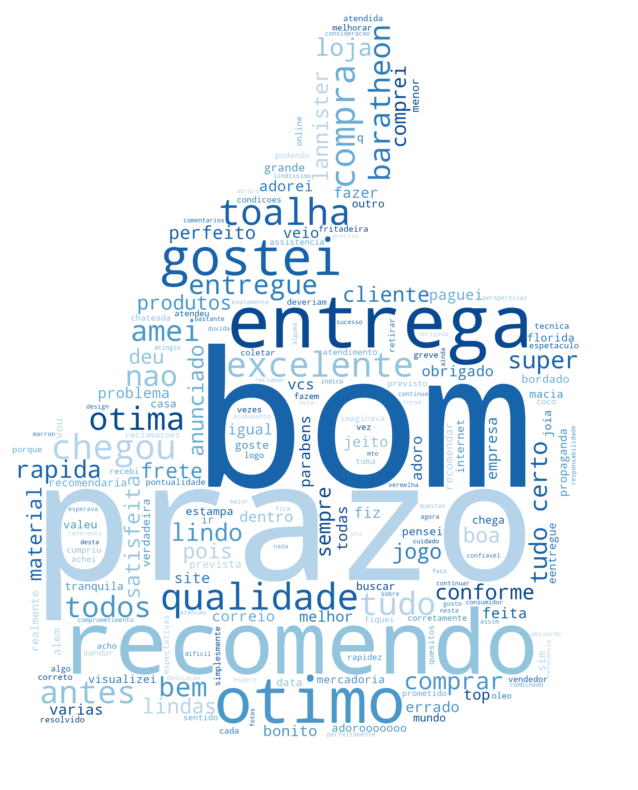

In [278]:
plot_wordcloud(unigrams_d5s, '5s')

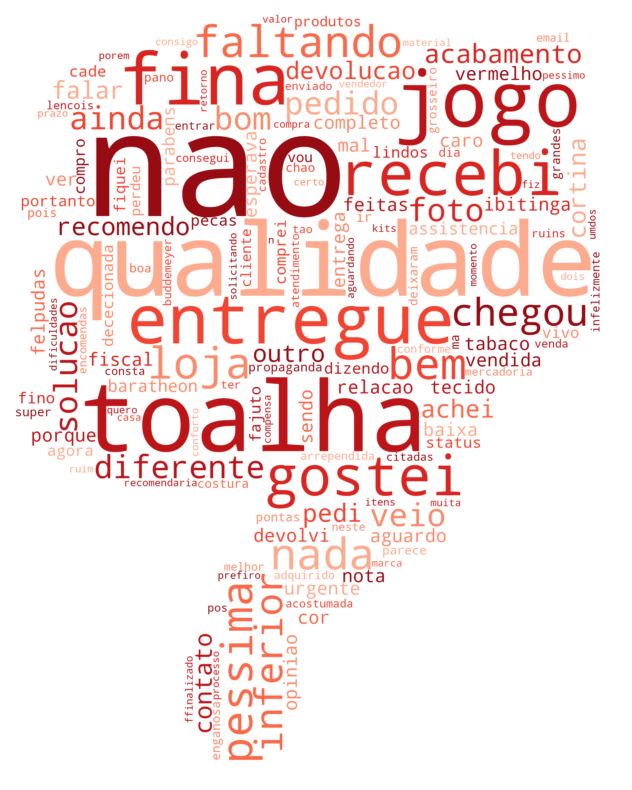

In [279]:
plot_wordcloud(unigrams_d1s, '1s')


tfidf sur les chaines de commentaires  
représentations tfidf  
regarder   

In [280]:
def worldcloud_product(product_id: str,
                       plot_style: str = 'both',
                       stats: bool = True):
    print(f'Product searched: {product_id}')

    def rgb_float_to_int(rgb):
        return tuple(int(255 * c) for c in rgb)

    WORDCLOUD_1S_PALETTE = [
        rgb_float_to_int(rgb)
        for rgb in sns.color_palette('Reds', n_colors=9)[2:]
    ]
    WORDCLOUD_5S_PALETTE = [
        rgb_float_to_int(rgb)
        for rgb in sns.color_palette('Blues', n_colors=9)[2:]
    ]

    def get_1s_color(*args, **kwargs):
        return random.choice(WORDCLOUD_1S_PALETTE)

    def get_5s_color(*args, **kwargs):
        return random.choice(WORDCLOUD_5S_PALETTE)

    def plot_wordcloud(words: list, style: str):
        if style == '1s':
            color_function = get_1s_color
            mask_fn = 'thumbs_down.png'
        elif style == '5s':
            color_function = get_5s_color
            mask_fn = 'thumbs_up.png'

        mask = np.array(Image.open(f'./input/{mask_fn}'))

        wordcloud = WordCloud(background_color='white',
                              mask=mask,
                              random_state=42,
                              stopwords=STOP_WORDS)
        wordcloud.generate(' '.join(words))
        wordcloud.recolor(color_func=color_function)

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.gcf().set_size_inches(16, 10)
        plt.show()

    product_link = order_item[order_item['product_id'] == product_id]

    if len(product_link) == 0:
        return print(f'\nThis product\'s id {product_id} was not found')

    reviews_order = reviews_na[reviews_na['order_id'].isin(
        product_link['order_id'])]

    if len(reviews_order) == 0:
        return print(f'\nThere no reviews founded for {product_id}')

    rev_len = len(reviews_order)
    ps_5 = len(
        reviews_order[reviews_order['review_score'] == 5]) * 100 / rev_len
    ps_1 = len(
        reviews_order[reviews_order['review_score'] == 1]) * 100 / rev_len
    avg_s = reviews_order['review_score'].mean()

    reviews_delivered_1s = reviews_prod[(reviews_prod['review_score'] == 1) & (
        reviews_prod['order_delivered_customer_date'] <
        reviews_prod['review_creation_date'])]
    reviews_delivered_5s = reviews_prod[(reviews_prod['review_score'] == 5) & (
        reviews_prod['order_delivered_customer_date'] <
        reviews_prod['review_creation_date'])]

    unigrams_d5s, bigrams_d5s, trigrams_d5s = ngrams(
        reviews_delivered_5s['review_comment_words'])
    unigrams_d1s, bigrams_d1s, trigrams_d1s = ngrams(
        reviews_delivered_1s['review_comment_words'])

    if stats:
        print(
            f'\nTotal number of reviews: {rev_len}',
            '\nPercentage of 5 star reviews: {:.2f}%'.format(ps_5),
            '\nPercentage of 1 star reviews: {:.2f}%'.format(ps_1),
            '\nAverage review score: {:.2f}'.format(avg_s),
        )

    if plot_style == 'both':
        plot_wordcloud(unigrams_d5s, '5s')
        plot_wordcloud(unigrams_d1s, '1s')
        return
    elif plot_style == '5s':
        return plot_wordcloud(unigrams_d5s, '5s')
    elif plot_style == '1s':
        return plot_wordcloud(unigrams_d1s, '1s')


Product searched: 99a4788cb24856965c36a24e339b6058

Total number of reviews: 216 
Percentage of 5 star reviews: 43.52% 
Percentage of 1 star reviews: 18.98% 
Average review score: 3.59


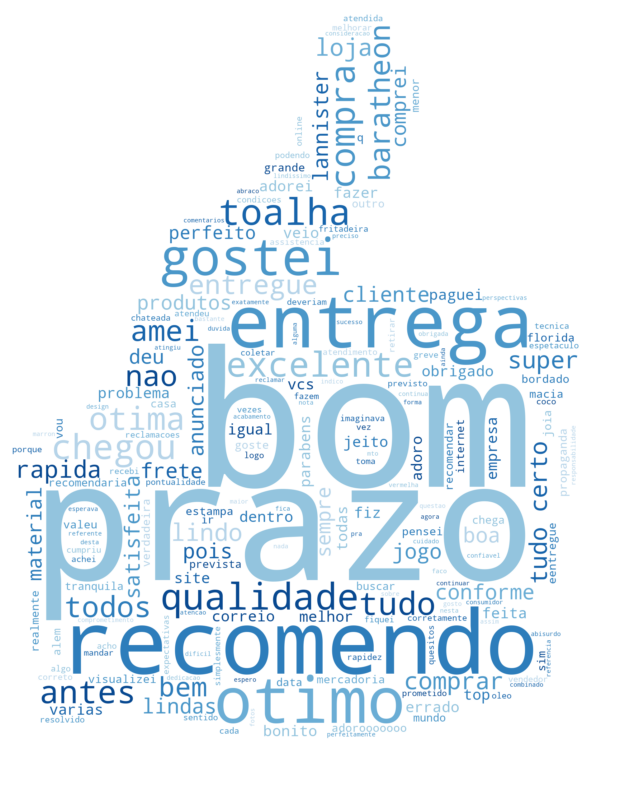

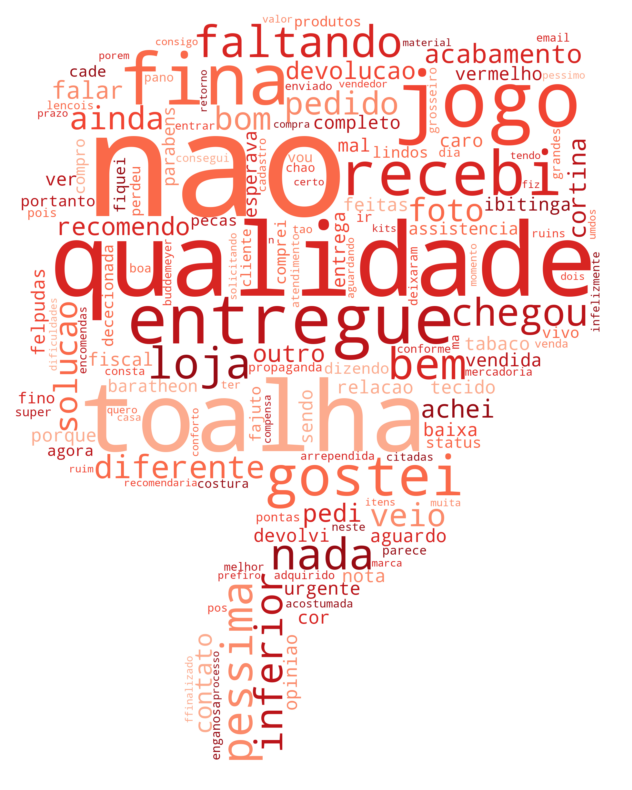

In [282]:
worldcloud_product('99a4788cb24856965c36a24e339b6058', plot_style='both', stats=True)